In [10]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

In [11]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

cuda is available!


In [12]:
train_data = MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data,
                         batch_size=4,
                         shuffle=True)
test_data = MNIST('mnist', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data,
                         batch_size=4,
                         shuffle=False)

Label: tensor(1)


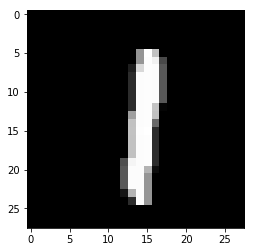

In [13]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

# matplotlibで1つ目のデータを可視化してみる
npimg = images[0].numpy()
npimg = npimg.reshape((28, 28))
plt.imshow(npimg, cmap='gray')
print('Label:', labels[0])

In [14]:
images[0].size()

torch.Size([1, 28, 28])

In [15]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class MlpMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 50) # 入力層から隠れ層へ
        self.l2 = nn.Linear(50, 10) # 隠れ層から出力層へ
        
    def forward(self, x):# Nはバッチサイズ　データひとつのシェイプは(1,28,28)
        x = x.view(-1, 28 * 28) # テンソルのリサイズ: (N, 1, 28, 28) --> (N, 784)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
net = MlpMnist()
print(net)
if cuda:
    net.cuda()

MlpMnist(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)


In [16]:
# コスト関数と最適化手法を定義
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [18]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        # Variableに変換
        if cuda:
            inputs = Variable(inputs).cuda()
            labels = Variable(labels).cuda()
        else:
            inputs = Variable(inputs)
            labels = Variable(labels)
        
        # 勾配情報をリセット
        optimizer.zero_grad()
        
        # 順伝播
        outputs = net(inputs)
        
        # コスト関数を使ってロスを計算する
        loss = criterion(outputs, labels)
        
        # 逆伝播
        loss.backward()
        
        # パラメータの更新
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 5000 == 4999:
            print('%d %d loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
print('Finished Training')

1 5000 loss: 2.940
1 10000 loss: 1.503
1 15000 loss: 1.275
2 5000 loss: 1.077
2 10000 loss: 0.947
2 15000 loss: 0.882
3 5000 loss: 0.765
3 10000 loss: 0.725
3 15000 loss: 0.704
Finished Training


In [26]:
import torch

correct = 0
total = 0
for data in test_loader:
    inputs, labels = data
    if cuda:
        inputs=Variable(inputs).cuda()
    else:
        inputs=Variable(inputs)
    outputs = net(inputs)
    _, predicted= torch.max(outputs.cpu().data,1)#2番目の引数はどの次元について最大のものを取ってくるかを指定している(axis的なサムシング)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy %d / %d = %f' % (correct, total, int(correct) / total))

Accuracy 9607 / 10000 = 0.960700
